# Estimating H_0


### Is the Universe Accelerating today? 
### How fast is the acceleration today? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

We can use the Supernova Data sets from Supernova Cosmology Project website http://supernova.lbl.gov/Union/

Let us take Absolute Magnitude M(with systematics) as -19.3081547178 for all SNIa - standard candles

In [154]:
# import data
file1 = open('sn.txt', 'r')
Lines = file1.readlines()
 
z = []
distance_mod = []

for line in Lines:
    x = line.split()
    if float(x[1]) < 0.1:
        z.append(float(x[1]))
        distance_mod.append(float(x[2]))

# data preprocessing
z = np.array(z)
distance_mod = np.array(distance_mod)

c = 3 * 1e5
distance = 71 * distance_mod / c

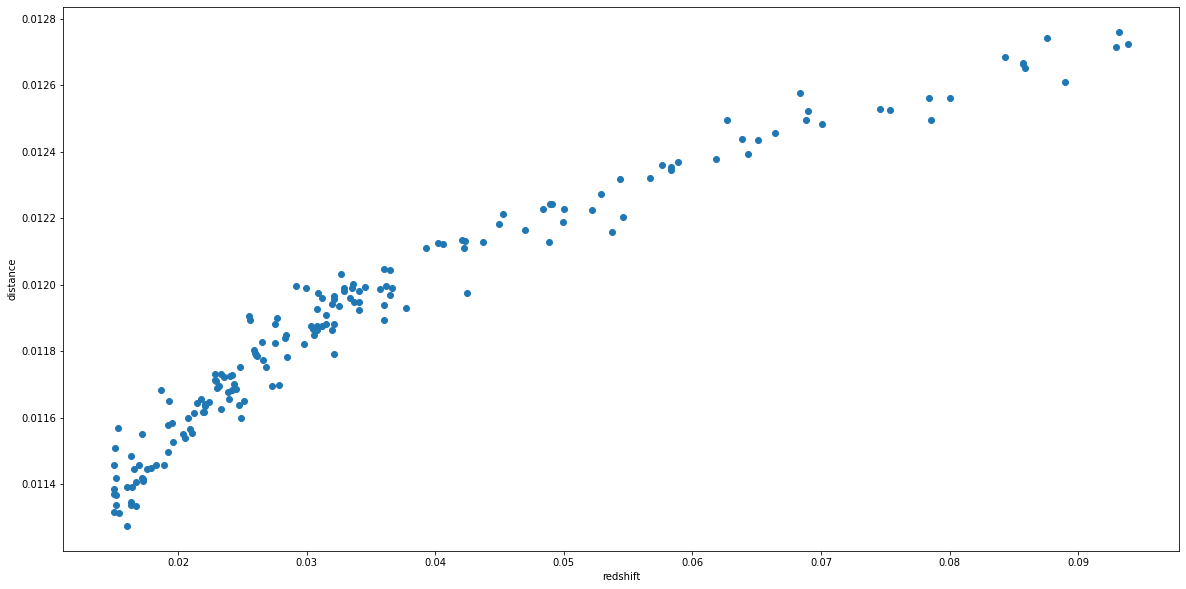

In [73]:
plt.scatter(z, distance) 
plt.xlabel('redshift')
plt.ylabel('distance')
plt.show()

### 0th order approximation - Linear Hubble Law

In [114]:
def model(theta,z=z): # model2
    m = theta
    return m * z + 0.008

### 1st order approximation

In [145]:
def model(theta,z=z): # model1
    m = theta
    return m * z * (z + 1) + 0.008

Here again we are using simplest Likelihood function. But there are many other likelihood function specifically for Cosmology today. 

In [146]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

We can set prior for the slope. 1/m = H_0 - the range can be from 60km/sec/Mpc to 90km/sec/Mpc

In [147]:
def lnprior(theta):
    m = theta
    if 0.011 < m < 0.016:
        return 0.0
    return -np.inf

In [148]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [149]:
distance_err = 0.05 * np.mean(distance)
data = (z, distance,distance_err)
nwalkers = 128
niter = 500
initial = np.array([0.015])
ndim = len(initial)
p0 = [np.array(initial) + 1e-15 * np.random.randn(ndim) for i in range(nwalkers)]

In [150]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [151]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


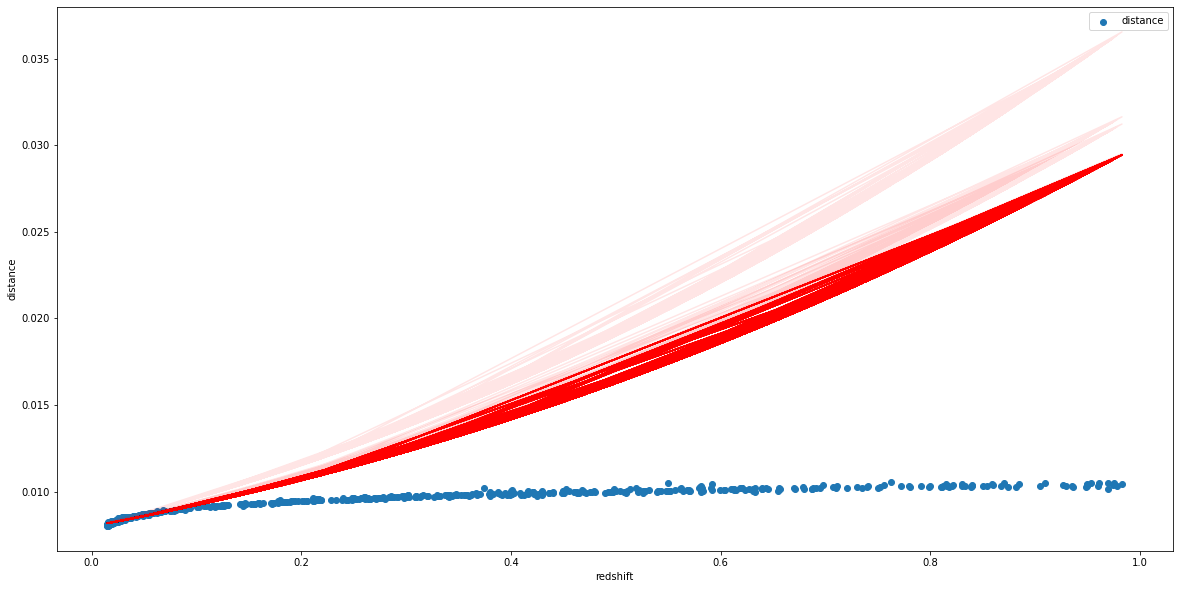

In [152]:
def plotter(sampler,z=z,distance=distance):
    plt.scatter(z,distance,label='distance')                                                 # distance vs z
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(z, model(theta, z), color="r", alpha=0.1)                                   # red lines
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('redshift')
    plt.ylabel('distance')
    plt.legend()
    plt.show()
    
#sampler= main(p0)
plotter(sampler)

In [153]:
samples = sampler.flatchain
best = samples[np.argmax(sampler.flatlnprobability)][0] # best value of theta
print(1/best)

90.90909088625632


To see the posterior probability distribution, we can make the following plot. We see that most probable value within redshift 0.1 is

A) 0th order - 79

B) 1st order - 84 (too high!)

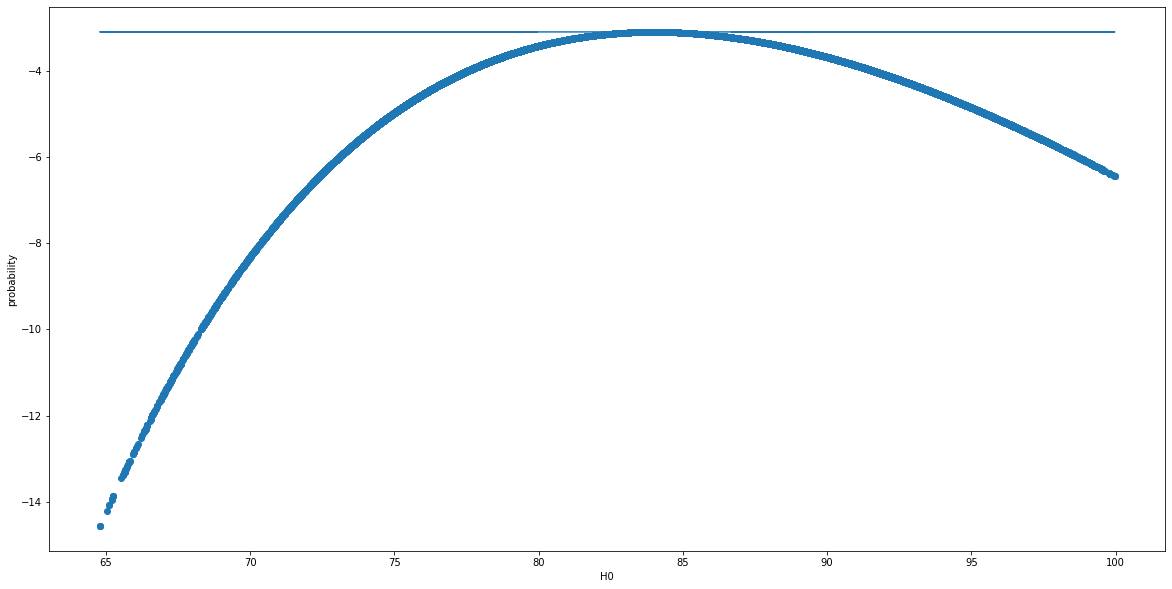

In [132]:
p = sampler.flatlnprobability # probability of different theta
plt.scatter(1/samples, p) # p vs H0
plt.plot(1/samples, p[np.argmax(p)] * np.ones(samples.shape[0])) # best selection
plt.xlabel('H0')
plt.ylabel('probability')
plt.show()